<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[09:14:38] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


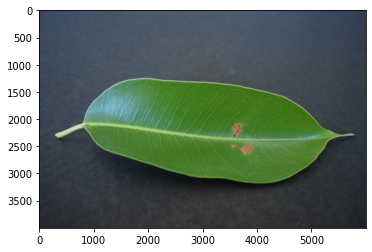

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

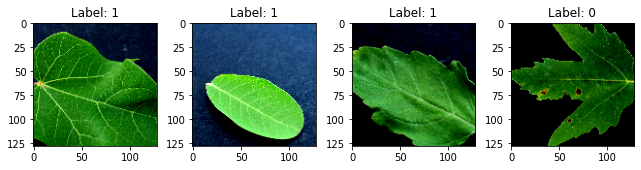

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[09:14:44] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[09:14:46] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.217819230828976 samples/sec                   batch loss = 0.41179800033569336 | accuracy = 0.55


Epoch[1] Batch[10] Speed: 1.263310997832663 samples/sec                   batch loss = 0.3471720218658447 | accuracy = 0.5


Epoch[1] Batch[15] Speed: 1.2272798329510555 samples/sec                   batch loss = 1.3590754270553589 | accuracy = 0.55


Epoch[1] Batch[20] Speed: 1.2627519977071 samples/sec                   batch loss = 0.8885393142700195 | accuracy = 0.575


Epoch[1] Batch[25] Speed: 1.2455531459481883 samples/sec                   batch loss = 0.6731448769569397 | accuracy = 0.58


Epoch[1] Batch[30] Speed: 1.2255726686130548 samples/sec                   batch loss = 0.4761806130409241 | accuracy = 0.575


Epoch[1] Batch[35] Speed: 1.2620645521496308 samples/sec                   batch loss = 0.4178767502307892 | accuracy = 0.5714285714285714


Epoch[1] Batch[40] Speed: 1.275169276789117 samples/sec                   batch loss = 0.9083158373832703 | accuracy = 0.5875


Epoch[1] Batch[45] Speed: 1.2706769969601694 samples/sec                   batch loss = 0.35327738523483276 | accuracy = 0.5944444444444444


Epoch[1] Batch[50] Speed: 1.2551589195373216 samples/sec                   batch loss = 0.6876364946365356 | accuracy = 0.58


Epoch[1] Batch[55] Speed: 1.2526019134242747 samples/sec                   batch loss = 1.0021542310714722 | accuracy = 0.5727272727272728


Epoch[1] Batch[60] Speed: 1.2562004114402092 samples/sec                   batch loss = 0.5112031102180481 | accuracy = 0.5875


Epoch[1] Batch[65] Speed: 1.2662751279957698 samples/sec                   batch loss = 0.4600246250629425 | accuracy = 0.5923076923076923


Epoch[1] Batch[70] Speed: 1.2652221183951213 samples/sec                   batch loss = 0.5151928663253784 | accuracy = 0.5964285714285714


Epoch[1] Batch[75] Speed: 1.2700933840092328 samples/sec                   batch loss = 0.7219991087913513 | accuracy = 0.5933333333333334


Epoch[1] Batch[80] Speed: 1.2647914692772033 samples/sec                   batch loss = 0.49172061681747437 | accuracy = 0.596875


Epoch[1] Batch[85] Speed: 1.2778049426202365 samples/sec                   batch loss = 0.5171986818313599 | accuracy = 0.6029411764705882


Epoch[1] Batch[90] Speed: 1.2651911094942936 samples/sec                   batch loss = 0.88443922996521 | accuracy = 0.6055555555555555


Epoch[1] Batch[95] Speed: 1.2689500313016755 samples/sec                   batch loss = 0.4903129041194916 | accuracy = 0.6131578947368421


Epoch[1] Batch[100] Speed: 1.2637411151526237 samples/sec                   batch loss = 1.1674585342407227 | accuracy = 0.62


Epoch[1] Batch[105] Speed: 1.2681996438171435 samples/sec                   batch loss = 0.44184622168540955 | accuracy = 0.6238095238095238


Epoch[1] Batch[110] Speed: 1.26735861224319 samples/sec                   batch loss = 0.9124784469604492 | accuracy = 0.6136363636363636


Epoch[1] Batch[115] Speed: 1.2634036576559793 samples/sec                   batch loss = 0.18469280004501343 | accuracy = 0.6152173913043478


Epoch[1] Batch[120] Speed: 1.259732239201729 samples/sec                   batch loss = 0.5322561860084534 | accuracy = 0.6208333333333333


Epoch[1] Batch[125] Speed: 1.2640820864462188 samples/sec                   batch loss = 0.6520877480506897 | accuracy = 0.624


Epoch[1] Batch[130] Speed: 1.268931124028422 samples/sec                   batch loss = 0.4322044849395752 | accuracy = 0.6269230769230769


Epoch[1] Batch[135] Speed: 1.2653497002328087 samples/sec                   batch loss = 0.6124264597892761 | accuracy = 0.6296296296296297


Epoch[1] Batch[140] Speed: 1.2710625505185364 samples/sec                   batch loss = 0.6004734039306641 | accuracy = 0.6285714285714286


Epoch[1] Batch[145] Speed: 1.2638037539994764 samples/sec                   batch loss = 0.7748627662658691 | accuracy = 0.6224137931034482


Epoch[1] Batch[150] Speed: 1.2665479527588301 samples/sec                   batch loss = 0.43026477098464966 | accuracy = 0.6283333333333333


Epoch[1] Batch[155] Speed: 1.2714710784788499 samples/sec                   batch loss = 0.4604611396789551 | accuracy = 0.6290322580645161


Epoch[1] Batch[160] Speed: 1.2650574546756417 samples/sec                   batch loss = 0.8732462525367737 | accuracy = 0.628125


Epoch[1] Batch[165] Speed: 1.2637858565524724 samples/sec                   batch loss = 0.6092345714569092 | accuracy = 0.6287878787878788


Epoch[1] Batch[170] Speed: 1.2646183384710383 samples/sec                   batch loss = 0.4111452102661133 | accuracy = 0.6338235294117647


Epoch[1] Batch[175] Speed: 1.2687676044248768 samples/sec                   batch loss = 0.7023301720619202 | accuracy = 0.6357142857142857


Epoch[1] Batch[180] Speed: 1.2666152688855892 samples/sec                   batch loss = 0.27410274744033813 | accuracy = 0.6416666666666667


Epoch[1] Batch[185] Speed: 1.277253172879248 samples/sec                   batch loss = 0.3065391778945923 | accuracy = 0.6418918918918919


Epoch[1] Batch[190] Speed: 1.265478166879249 samples/sec                   batch loss = 0.24425020813941956 | accuracy = 0.6394736842105263


Epoch[1] Batch[195] Speed: 1.2681043622016797 samples/sec                   batch loss = 0.44739973545074463 | accuracy = 0.6410256410256411


Epoch[1] Batch[200] Speed: 1.2806668511397574 samples/sec                   batch loss = 0.43591001629829407 | accuracy = 0.645


Epoch[1] Batch[205] Speed: 1.2689342911973458 samples/sec                   batch loss = 0.6465604901313782 | accuracy = 0.6451219512195122


Epoch[1] Batch[210] Speed: 1.2698078813054852 samples/sec                   batch loss = 0.9040891528129578 | accuracy = 0.6452380952380953


Epoch[1] Batch[215] Speed: 1.2648799597101301 samples/sec                   batch loss = 0.6251233816146851 | accuracy = 0.6511627906976745


Epoch[1] Batch[220] Speed: 1.258884071453451 samples/sec                   batch loss = 0.303537517786026 | accuracy = 0.6534090909090909


Epoch[1] Batch[225] Speed: 1.2618243080625753 samples/sec                   batch loss = 0.3359217643737793 | accuracy = 0.6566666666666666


Epoch[1] Batch[230] Speed: 1.2532368643949734 samples/sec                   batch loss = 0.3491903245449066 | accuracy = 0.6619565217391304


Epoch[1] Batch[235] Speed: 1.2593669512497576 samples/sec                   batch loss = 0.8270962834358215 | accuracy = 0.6648936170212766


Epoch[1] Batch[240] Speed: 1.2530973932518845 samples/sec                   batch loss = 0.6507900357246399 | accuracy = 0.66875


Epoch[1] Batch[245] Speed: 1.2672030589526966 samples/sec                   batch loss = 0.5829241275787354 | accuracy = 0.6693877551020408


Epoch[1] Batch[250] Speed: 1.2740559543104524 samples/sec                   batch loss = 0.3084566593170166 | accuracy = 0.669


Epoch[1] Batch[255] Speed: 1.264532172082094 samples/sec                   batch loss = 0.1629171073436737 | accuracy = 0.6715686274509803


Epoch[1] Batch[260] Speed: 1.2698370985810659 samples/sec                   batch loss = 0.30243757367134094 | accuracy = 0.675


Epoch[1] Batch[265] Speed: 1.2675587338598377 samples/sec                   batch loss = 0.9396241903305054 | accuracy = 0.6726415094339623


Epoch[1] Batch[270] Speed: 1.2675763552492452 samples/sec                   batch loss = 0.22722046077251434 | accuracy = 0.6731481481481482


Epoch[1] Batch[275] Speed: 1.2680901766263537 samples/sec                   batch loss = 0.6595574021339417 | accuracy = 0.6709090909090909


Epoch[1] Batch[280] Speed: 1.2680597937254485 samples/sec                   batch loss = 0.5829448699951172 | accuracy = 0.6741071428571429


Epoch[1] Batch[285] Speed: 1.274598767141469 samples/sec                   batch loss = 0.5487455725669861 | accuracy = 0.6754385964912281


Epoch[1] Batch[290] Speed: 1.264655801636501 samples/sec                   batch loss = 0.8735657334327698 | accuracy = 0.6767241379310345


Epoch[1] Batch[295] Speed: 1.2645585735884548 samples/sec                   batch loss = 1.0190386772155762 | accuracy = 0.6788135593220339


Epoch[1] Batch[300] Speed: 1.2642112484341674 samples/sec                   batch loss = 0.4745040535926819 | accuracy = 0.68


Epoch[1] Batch[305] Speed: 1.265317730789678 samples/sec                   batch loss = 0.47280246019363403 | accuracy = 0.6819672131147541


Epoch[1] Batch[310] Speed: 1.2697587724011867 samples/sec                   batch loss = 0.45746827125549316 | accuracy = 0.6854838709677419


Epoch[1] Batch[315] Speed: 1.260332213494839 samples/sec                   batch loss = 0.6990163326263428 | accuracy = 0.6865079365079365


Epoch[1] Batch[320] Speed: 1.2631765035480595 samples/sec                   batch loss = 0.4857310652732849 | accuracy = 0.6875


Epoch[1] Batch[325] Speed: 1.2654421821351913 samples/sec                   batch loss = 0.8900809288024902 | accuracy = 0.686923076923077


Epoch[1] Batch[330] Speed: 1.278899579661604 samples/sec                   batch loss = 0.24320408701896667 | accuracy = 0.6893939393939394


Epoch[1] Batch[335] Speed: 1.2695006047018815 samples/sec                   batch loss = 0.7624193429946899 | accuracy = 0.6902985074626866


Epoch[1] Batch[340] Speed: 1.2736860844925002 samples/sec                   batch loss = 0.4408927261829376 | accuracy = 0.6897058823529412


Epoch[1] Batch[345] Speed: 1.2720872083902537 samples/sec                   batch loss = 0.6116631031036377 | accuracy = 0.6891304347826087


Epoch[1] Batch[350] Speed: 1.2681628331256165 samples/sec                   batch loss = 0.1516999751329422 | accuracy = 0.6892857142857143


Epoch[1] Batch[355] Speed: 1.268432252436618 samples/sec                   batch loss = 0.5083491206169128 | accuracy = 0.6894366197183098


Epoch[1] Batch[360] Speed: 1.2761072847316417 samples/sec                   batch loss = 0.18569251894950867 | accuracy = 0.6902777777777778


Epoch[1] Batch[365] Speed: 1.2663167037152183 samples/sec                   batch loss = 0.6758662462234497 | accuracy = 0.689041095890411


Epoch[1] Batch[370] Speed: 1.2721630246410642 samples/sec                   batch loss = 0.5549635291099548 | accuracy = 0.6891891891891891


Epoch[1] Batch[375] Speed: 1.2704498176511119 samples/sec                   batch loss = 0.5352802276611328 | accuracy = 0.6886666666666666


Epoch[1] Batch[380] Speed: 1.2691705297812852 samples/sec                   batch loss = 0.9237775802612305 | accuracy = 0.6881578947368421


Epoch[1] Batch[385] Speed: 1.2579896913207327 samples/sec                   batch loss = 0.8309847116470337 | accuracy = 0.6883116883116883


Epoch[1] Batch[390] Speed: 1.2672144489440456 samples/sec                   batch loss = 1.0193395614624023 | accuracy = 0.6852564102564103


Epoch[1] Batch[395] Speed: 1.2634625522262621 samples/sec                   batch loss = 0.3313480615615845 | accuracy = 0.6854430379746835


Epoch[1] Batch[400] Speed: 1.2617317848608425 samples/sec                   batch loss = 0.835509181022644 | accuracy = 0.685625


Epoch[1] Batch[405] Speed: 1.2604300237072288 samples/sec                   batch loss = 0.8739680051803589 | accuracy = 0.6839506172839506


Epoch[1] Batch[410] Speed: 1.268135514072026 samples/sec                   batch loss = 0.7777653932571411 | accuracy = 0.6835365853658537


Epoch[1] Batch[415] Speed: 1.2635670346179921 samples/sec                   batch loss = 0.42904213070869446 | accuracy = 0.6855421686746987


Epoch[1] Batch[420] Speed: 1.271665946593295 samples/sec                   batch loss = 0.6946367621421814 | accuracy = 0.6875


Epoch[1] Batch[425] Speed: 1.2686453761015908 samples/sec                   batch loss = 0.47823968529701233 | accuracy = 0.6882352941176471


Epoch[1] Batch[430] Speed: 1.2684193061865208 samples/sec                   batch loss = 0.8998168706893921 | accuracy = 0.6895348837209302


Epoch[1] Batch[435] Speed: 1.2659851296767255 samples/sec                   batch loss = 0.41168540716171265 | accuracy = 0.6902298850574713


Epoch[1] Batch[440] Speed: 1.2628199564984939 samples/sec                   batch loss = 0.9882004857063293 | accuracy = 0.6903409090909091


Epoch[1] Batch[445] Speed: 1.2612923189436946 samples/sec                   batch loss = 0.38637498021125793 | accuracy = 0.6910112359550562


Epoch[1] Batch[450] Speed: 1.2744969060973679 samples/sec                   batch loss = 0.6188800930976868 | accuracy = 0.6916666666666667


Epoch[1] Batch[455] Speed: 1.2684304303558098 samples/sec                   batch loss = 0.23204314708709717 | accuracy = 0.6934065934065934


Epoch[1] Batch[460] Speed: 1.2673973868546815 samples/sec                   batch loss = 1.033218502998352 | accuracy = 0.6929347826086957


Epoch[1] Batch[465] Speed: 1.2707031744675643 samples/sec                   batch loss = 0.754954993724823 | accuracy = 0.6940860215053763


Epoch[1] Batch[470] Speed: 1.2665753946909002 samples/sec                   batch loss = 0.24776268005371094 | accuracy = 0.6962765957446808


Epoch[1] Batch[475] Speed: 1.2707282943398142 samples/sec                   batch loss = 0.44674068689346313 | accuracy = 0.6963157894736842


Epoch[1] Batch[480] Speed: 1.268374332008451 samples/sec                   batch loss = 0.573678195476532 | accuracy = 0.6979166666666666


Epoch[1] Batch[485] Speed: 1.2701472305552137 samples/sec                   batch loss = 0.7178505659103394 | accuracy = 0.6989690721649484


Epoch[1] Batch[490] Speed: 1.2750545332062424 samples/sec                   batch loss = 0.20056387782096863 | accuracy = 0.7005102040816327


Epoch[1] Batch[495] Speed: 1.2703422701875777 samples/sec                   batch loss = 1.836201786994934 | accuracy = 0.701010101010101


Epoch[1] Batch[500] Speed: 1.2621799132035847 samples/sec                   batch loss = 0.3731847405433655 | accuracy = 0.701


Epoch[1] Batch[505] Speed: 1.261821081384118 samples/sec                   batch loss = 0.3254892826080322 | accuracy = 0.7014851485148514


Epoch[1] Batch[510] Speed: 1.2674650805665133 samples/sec                   batch loss = 0.9904155135154724 | accuracy = 0.7004901960784313


Epoch[1] Batch[515] Speed: 1.2681874692113038 samples/sec                   batch loss = 0.8232437968254089 | accuracy = 0.7004854368932039


Epoch[1] Batch[520] Speed: 1.277119096349962 samples/sec                   batch loss = 0.6781660318374634 | accuracy = 0.7


Epoch[1] Batch[525] Speed: 1.266388774763311 samples/sec                   batch loss = 0.48373857140541077 | accuracy = 0.6995238095238095


Epoch[1] Batch[530] Speed: 1.2672073660682084 samples/sec                   batch loss = 0.6584722995758057 | accuracy = 0.6981132075471698


Epoch[1] Batch[535] Speed: 1.2661685728131138 samples/sec                   batch loss = 0.7285551428794861 | accuracy = 0.6985981308411215


Epoch[1] Batch[540] Speed: 1.2702478204404373 samples/sec                   batch loss = 0.5693139433860779 | accuracy = 0.6986111111111111


Epoch[1] Batch[545] Speed: 1.2675605534371475 samples/sec                   batch loss = 0.17139701545238495 | accuracy = 0.6990825688073394


Epoch[1] Batch[550] Speed: 1.266545849245163 samples/sec                   batch loss = 0.7035558819770813 | accuracy = 0.7004545454545454


Epoch[1] Batch[555] Speed: 1.2598241855645997 samples/sec                   batch loss = 0.26724639534950256 | accuracy = 0.7013513513513514


Epoch[1] Batch[560] Speed: 1.267780186053056 samples/sec                   batch loss = 0.4651002287864685 | accuracy = 0.7008928571428571


Epoch[1] Batch[565] Speed: 1.2638421209795543 samples/sec                   batch loss = 0.7782683968544006 | accuracy = 0.7013274336283186


Epoch[1] Batch[570] Speed: 1.2683132527843453 samples/sec                   batch loss = 0.1817207783460617 | accuracy = 0.7013157894736842


Epoch[1] Batch[575] Speed: 1.2700117575065002 samples/sec                   batch loss = 0.6771272420883179 | accuracy = 0.701304347826087


Epoch[1] Batch[580] Speed: 1.2684999608348024 samples/sec                   batch loss = 0.3211885094642639 | accuracy = 0.7021551724137931


Epoch[1] Batch[585] Speed: 1.2652081880547092 samples/sec                   batch loss = 1.2635780572891235 | accuracy = 0.7017094017094017


Epoch[1] Batch[590] Speed: 1.265922656494344 samples/sec                   batch loss = 0.6169682741165161 | accuracy = 0.7021186440677966


Epoch[1] Batch[595] Speed: 1.2712846508126774 samples/sec                   batch loss = 0.17929242551326752 | accuracy = 0.7033613445378152


Epoch[1] Batch[600] Speed: 1.267352006434805 samples/sec                   batch loss = 1.0846083164215088 | accuracy = 0.7033333333333334


Epoch[1] Batch[605] Speed: 1.2675064471859596 samples/sec                   batch loss = 0.4187129735946655 | accuracy = 0.7024793388429752


Epoch[1] Batch[610] Speed: 1.276150188096046 samples/sec                   batch loss = 0.5370287299156189 | accuracy = 0.7028688524590164


Epoch[1] Batch[615] Speed: 1.2692037503856282 samples/sec                   batch loss = 0.7377686500549316 | accuracy = 0.7032520325203252


Epoch[1] Batch[620] Speed: 1.2630234964364482 samples/sec                   batch loss = 0.6268101334571838 | accuracy = 0.7036290322580645


Epoch[1] Batch[625] Speed: 1.263414979449156 samples/sec                   batch loss = 0.21416112780570984 | accuracy = 0.7048


Epoch[1] Batch[630] Speed: 1.2711034781737742 samples/sec                   batch loss = 0.38541555404663086 | accuracy = 0.7047619047619048


Epoch[1] Batch[635] Speed: 1.2800528342119835 samples/sec                   batch loss = 0.5102318525314331 | accuracy = 0.7047244094488189


Epoch[1] Batch[640] Speed: 1.2638321243955781 samples/sec                   batch loss = 1.4980422258377075 | accuracy = 0.704296875


Epoch[1] Batch[645] Speed: 1.2717275419650662 samples/sec                   batch loss = 0.7143915891647339 | accuracy = 0.7046511627906977


Epoch[1] Batch[650] Speed: 1.2745062007267107 samples/sec                   batch loss = 0.6075712442398071 | accuracy = 0.7053846153846154


Epoch[1] Batch[655] Speed: 1.2721284914366922 samples/sec                   batch loss = 0.7068180441856384 | accuracy = 0.7061068702290076


Epoch[1] Batch[660] Speed: 1.2764053382681662 samples/sec                   batch loss = 0.84904545545578 | accuracy = 0.706060606060606


Epoch[1] Batch[665] Speed: 1.2746010911575336 samples/sec                   batch loss = 1.4431663751602173 | accuracy = 0.706015037593985


Epoch[1] Batch[670] Speed: 1.2808572143160997 samples/sec                   batch loss = 0.7296630144119263 | accuracy = 0.7048507462686567


Epoch[1] Batch[675] Speed: 1.2686965095755218 samples/sec                   batch loss = 0.9508413672447205 | accuracy = 0.7051851851851851


Epoch[1] Batch[680] Speed: 1.268680296076541 samples/sec                   batch loss = 0.6561647057533264 | accuracy = 0.7044117647058824


Epoch[1] Batch[685] Speed: 1.269151807952578 samples/sec                   batch loss = 0.3349064588546753 | accuracy = 0.704014598540146


Epoch[1] Batch[690] Speed: 1.2591059044754909 samples/sec                   batch loss = 0.5033459663391113 | accuracy = 0.7039855072463768


Epoch[1] Batch[695] Speed: 1.2624790956561105 samples/sec                   batch loss = 0.3644431233406067 | accuracy = 0.7039568345323741


Epoch[1] Batch[700] Speed: 1.2575194603072095 samples/sec                   batch loss = 0.35061368346214294 | accuracy = 0.705


Epoch[1] Batch[705] Speed: 1.2676536461517003 samples/sec                   batch loss = 0.5469620227813721 | accuracy = 0.7063829787234043


Epoch[1] Batch[710] Speed: 1.2695052156341524 samples/sec                   batch loss = 0.3917953073978424 | accuracy = 0.706338028169014


Epoch[1] Batch[715] Speed: 1.2634554160813054 samples/sec                   batch loss = 0.7234076261520386 | accuracy = 0.7066433566433566


Epoch[1] Batch[720] Speed: 1.2655033669634932 samples/sec                   batch loss = 0.5732526779174805 | accuracy = 0.7072916666666667


Epoch[1] Batch[725] Speed: 1.2743705706754982 samples/sec                   batch loss = 0.3064013123512268 | accuracy = 0.7079310344827586


Epoch[1] Batch[730] Speed: 1.2728142975178962 samples/sec                   batch loss = 0.8495483994483948 | accuracy = 0.7085616438356165


Epoch[1] Batch[735] Speed: 1.2741319086610237 samples/sec                   batch loss = 0.15833808481693268 | accuracy = 0.7091836734693877


Epoch[1] Batch[740] Speed: 1.2671295553616027 samples/sec                   batch loss = 0.7470452785491943 | accuracy = 0.7087837837837838


Epoch[1] Batch[745] Speed: 1.266772973451719 samples/sec                   batch loss = 0.32660889625549316 | accuracy = 0.7100671140939597


Epoch[1] Batch[750] Speed: 1.2690751022274225 samples/sec                   batch loss = 0.42133480310440063 | accuracy = 0.7106666666666667


Epoch[1] Batch[755] Speed: 1.2720496894409938 samples/sec                   batch loss = 0.8226578235626221 | accuracy = 0.7105960264900663


Epoch[1] Batch[760] Speed: 1.2692496476075137 samples/sec                   batch loss = 0.4840540885925293 | accuracy = 0.7115131578947368


Epoch[1] Batch[765] Speed: 1.2758869893675424 samples/sec                   batch loss = 0.5251315236091614 | accuracy = 0.711437908496732


Epoch[1] Batch[770] Speed: 1.2702346447590795 samples/sec                   batch loss = 0.3978263735771179 | accuracy = 0.712012987012987


Epoch[1] Batch[775] Speed: 1.2755159588355085 samples/sec                   batch loss = 0.5055753588676453 | accuracy = 0.7119354838709677


Epoch[1] Batch[780] Speed: 1.2715638791377306 samples/sec                   batch loss = 0.307248592376709 | accuracy = 0.7121794871794872


Epoch[1] Batch[785] Speed: 1.2684119221474104 samples/sec                   batch loss = 2.1001243591308594 | accuracy = 0.7124203821656051


[Epoch 1] training: accuracy=0.712246192893401
[Epoch 1] time cost: 649.4854273796082
[Epoch 1] validation: validation accuracy=0.7522222222222222


Epoch[2] Batch[5] Speed: 1.2662464566763922 samples/sec                   batch loss = 0.5111664533615112 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.2696889116801475 samples/sec                   batch loss = 0.2604485750198364 | accuracy = 0.725


Epoch[2] Batch[15] Speed: 1.2650270261548153 samples/sec                   batch loss = 0.4236620366573334 | accuracy = 0.7666666666666667


Epoch[2] Batch[20] Speed: 1.265788751578066 samples/sec                   batch loss = 0.38234373927116394 | accuracy = 0.775


Epoch[2] Batch[25] Speed: 1.2635521890720298 samples/sec                   batch loss = 0.4786529242992401 | accuracy = 0.75


Epoch[2] Batch[30] Speed: 1.2634715914589305 samples/sec                   batch loss = 0.7833058834075928 | accuracy = 0.7583333333333333


Epoch[2] Batch[35] Speed: 1.2610338856495935 samples/sec                   batch loss = 0.5956368446350098 | accuracy = 0.7642857142857142


Epoch[2] Batch[40] Speed: 1.2664053121157883 samples/sec                   batch loss = 0.3634103238582611 | accuracy = 0.7625


Epoch[2] Batch[45] Speed: 1.264692123007572 samples/sec                   batch loss = 0.6321708559989929 | accuracy = 0.7444444444444445


Epoch[2] Batch[50] Speed: 1.2600852463695187 samples/sec                   batch loss = 0.3560291528701782 | accuracy = 0.73


Epoch[2] Batch[55] Speed: 1.2730536253182119 samples/sec                   batch loss = 0.5303125977516174 | accuracy = 0.7181818181818181


Epoch[2] Batch[60] Speed: 1.2686586147669447 samples/sec                   batch loss = 0.2954169809818268 | accuracy = 0.7208333333333333


Epoch[2] Batch[65] Speed: 1.2675547116548482 samples/sec                   batch loss = 0.365669310092926 | accuracy = 0.7307692307692307


Epoch[2] Batch[70] Speed: 1.2666738894662515 samples/sec                   batch loss = 0.8546611666679382 | accuracy = 0.7142857142857143


Epoch[2] Batch[75] Speed: 1.2705776862258036 samples/sec                   batch loss = 0.59044349193573 | accuracy = 0.72


Epoch[2] Batch[80] Speed: 1.2656469502276808 samples/sec                   batch loss = 0.31885337829589844 | accuracy = 0.721875


Epoch[2] Batch[85] Speed: 1.2646835429679315 samples/sec                   batch loss = 0.4705476760864258 | accuracy = 0.7235294117647059


Epoch[2] Batch[90] Speed: 1.269667291969316 samples/sec                   batch loss = 0.5445746779441833 | accuracy = 0.725


Epoch[2] Batch[95] Speed: 1.2596909055497016 samples/sec                   batch loss = 0.2714427709579468 | accuracy = 0.7315789473684211


Epoch[2] Batch[100] Speed: 1.2664387705081255 samples/sec                   batch loss = 1.0248260498046875 | accuracy = 0.735


Epoch[2] Batch[105] Speed: 1.265752367191264 samples/sec                   batch loss = 0.7927187085151672 | accuracy = 0.7333333333333333


Epoch[2] Batch[110] Speed: 1.2718305998335884 samples/sec                   batch loss = 0.4142107367515564 | accuracy = 0.7272727272727273


Epoch[2] Batch[115] Speed: 1.270966260549047 samples/sec                   batch loss = 0.3767585754394531 | accuracy = 0.7326086956521739


Epoch[2] Batch[120] Speed: 1.266025922069588 samples/sec                   batch loss = 0.5269197225570679 | accuracy = 0.73125


Epoch[2] Batch[125] Speed: 1.2672176075493382 samples/sec                   batch loss = 0.33315393328666687 | accuracy = 0.738


Epoch[2] Batch[130] Speed: 1.2709087823915837 samples/sec                   batch loss = 0.7681872844696045 | accuracy = 0.7307692307692307


Epoch[2] Batch[135] Speed: 1.272105824011729 samples/sec                   batch loss = 0.6237654685974121 | accuracy = 0.7296296296296296


Epoch[2] Batch[140] Speed: 1.2671280241274625 samples/sec                   batch loss = 0.5961448550224304 | accuracy = 0.7303571428571428


Epoch[2] Batch[145] Speed: 1.2677516381305949 samples/sec                   batch loss = 0.4235946834087372 | accuracy = 0.7344827586206897


Epoch[2] Batch[150] Speed: 1.2671597979942018 samples/sec                   batch loss = 0.43903160095214844 | accuracy = 0.7366666666666667


Epoch[2] Batch[155] Speed: 1.265785027095916 samples/sec                   batch loss = 0.14590851962566376 | accuracy = 0.7338709677419355


Epoch[2] Batch[160] Speed: 1.2645844042879388 samples/sec                   batch loss = 0.5743694305419922 | accuracy = 0.7328125


Epoch[2] Batch[165] Speed: 1.2701705013683096 samples/sec                   batch loss = 0.10123778134584427 | accuracy = 0.7333333333333333


Epoch[2] Batch[170] Speed: 1.2692380289593161 samples/sec                   batch loss = 0.4456897974014282 | accuracy = 0.7382352941176471


Epoch[2] Batch[175] Speed: 1.2687203029160228 samples/sec                   batch loss = 0.46019887924194336 | accuracy = 0.7342857142857143


Epoch[2] Batch[180] Speed: 1.2678636338285876 samples/sec                   batch loss = 0.14622418582439423 | accuracy = 0.7375


Epoch[2] Batch[185] Speed: 1.2647445591128734 samples/sec                   batch loss = 0.4746752083301544 | accuracy = 0.7391891891891892


Epoch[2] Batch[190] Speed: 1.2653146770766501 samples/sec                   batch loss = 0.39219191670417786 | accuracy = 0.7381578947368421


Epoch[2] Batch[195] Speed: 1.270792012799711 samples/sec                   batch loss = 0.3962516784667969 | accuracy = 0.7397435897435898


Epoch[2] Batch[200] Speed: 1.2577306294584503 samples/sec                   batch loss = 0.7793869972229004 | accuracy = 0.7375


Epoch[2] Batch[205] Speed: 1.2606040933602929 samples/sec                   batch loss = 0.543378472328186 | accuracy = 0.7390243902439024


Epoch[2] Batch[210] Speed: 1.2618261112136067 samples/sec                   batch loss = 0.2694980502128601 | accuracy = 0.7404761904761905


Epoch[2] Batch[215] Speed: 1.2586744034221218 samples/sec                   batch loss = 0.09289200603961945 | accuracy = 0.7406976744186047


Epoch[2] Batch[220] Speed: 1.264773162457595 samples/sec                   batch loss = 0.3843156099319458 | accuracy = 0.7420454545454546


Epoch[2] Batch[225] Speed: 1.2698774667659627 samples/sec                   batch loss = 0.28638970851898193 | accuracy = 0.74


Epoch[2] Batch[230] Speed: 1.2735522723965482 samples/sec                   batch loss = 0.6244001984596252 | accuracy = 0.7391304347826086


Epoch[2] Batch[235] Speed: 1.2662993084843377 samples/sec                   batch loss = 0.33580535650253296 | accuracy = 0.7425531914893617


Epoch[2] Batch[240] Speed: 1.265889607426859 samples/sec                   batch loss = 0.4000777304172516 | accuracy = 0.7458333333333333


Epoch[2] Batch[245] Speed: 1.2670726150820104 samples/sec                   batch loss = 0.20763424038887024 | accuracy = 0.7479591836734694


Epoch[2] Batch[250] Speed: 1.268224760671675 samples/sec                   batch loss = 0.32082298398017883 | accuracy = 0.752


Epoch[2] Batch[255] Speed: 1.2654256699270487 samples/sec                   batch loss = 0.2104821801185608 | accuracy = 0.753921568627451


Epoch[2] Batch[260] Speed: 1.2723188332159137 samples/sec                   batch loss = 0.6109227538108826 | accuracy = 0.7519230769230769


Epoch[2] Batch[265] Speed: 1.2690396805604187 samples/sec                   batch loss = 0.3362824320793152 | accuracy = 0.7528301886792453


Epoch[2] Batch[270] Speed: 1.2683467161832365 samples/sec                   batch loss = 0.22052916884422302 | accuracy = 0.7537037037037037


Epoch[2] Batch[275] Speed: 1.2716625729972444 samples/sec                   batch loss = 0.8889294862747192 | accuracy = 0.7554545454545455


Epoch[2] Batch[280] Speed: 1.2728537929598747 samples/sec                   batch loss = 0.5129507184028625 | accuracy = 0.7535714285714286


Epoch[2] Batch[285] Speed: 1.262186560161972 samples/sec                   batch loss = 0.34398153424263 | accuracy = 0.7543859649122807


Epoch[2] Batch[290] Speed: 1.2622478104303798 samples/sec                   batch loss = 0.07107540965080261 | accuracy = 0.7543103448275862


Epoch[2] Batch[295] Speed: 1.2701830987344362 samples/sec                   batch loss = 0.7174398899078369 | accuracy = 0.7550847457627119


Epoch[2] Batch[300] Speed: 1.265197788206038 samples/sec                   batch loss = 0.2925470471382141 | accuracy = 0.7558333333333334


Epoch[2] Batch[305] Speed: 1.26899264671456 samples/sec                   batch loss = 0.17439216375350952 | accuracy = 0.7565573770491804


Epoch[2] Batch[310] Speed: 1.267329413175947 samples/sec                   batch loss = 1.0166358947753906 | accuracy = 0.757258064516129


Epoch[2] Batch[315] Speed: 1.261830856372525 samples/sec                   batch loss = 0.42051589488983154 | accuracy = 0.7563492063492063


Epoch[2] Batch[320] Speed: 1.2629652132352713 samples/sec                   batch loss = 0.3712576627731323 | accuracy = 0.753125


Epoch[2] Batch[325] Speed: 1.2616344366344987 samples/sec                   batch loss = 0.12053835391998291 | accuracy = 0.7546153846153846


Epoch[2] Batch[330] Speed: 1.2630482185053566 samples/sec                   batch loss = 0.2140377014875412 | accuracy = 0.7553030303030303


Epoch[2] Batch[335] Speed: 1.26210366810283 samples/sec                   batch loss = 0.2715113162994385 | accuracy = 0.7567164179104477


Epoch[2] Batch[340] Speed: 1.2666374541768073 samples/sec                   batch loss = 0.4466788172721863 | accuracy = 0.7566176470588235


Epoch[2] Batch[345] Speed: 1.273427574008628 samples/sec                   batch loss = 0.38712266087532043 | accuracy = 0.7565217391304347


Epoch[2] Batch[350] Speed: 1.2737163508090201 samples/sec                   batch loss = 0.49563318490982056 | accuracy = 0.7578571428571429


Epoch[2] Batch[355] Speed: 1.270805007529898 samples/sec                   batch loss = 0.43242835998535156 | accuracy = 0.7584507042253521


Epoch[2] Batch[360] Speed: 1.2665666934617403 samples/sec                   batch loss = 0.40427324175834656 | accuracy = 0.7569444444444444


Epoch[2] Batch[365] Speed: 1.2631329464754588 samples/sec                   batch loss = 0.5888693928718567 | accuracy = 0.7568493150684932


Epoch[2] Batch[370] Speed: 1.271189964570497 samples/sec                   batch loss = 0.5179896950721741 | accuracy = 0.7560810810810811


Epoch[2] Batch[375] Speed: 1.2624496460114796 samples/sec                   batch loss = 0.3841300904750824 | accuracy = 0.756


Epoch[2] Batch[380] Speed: 1.2675500191146227 samples/sec                   batch loss = 1.2525339126586914 | accuracy = 0.7532894736842105


Epoch[2] Batch[385] Speed: 1.2714860143265232 samples/sec                   batch loss = 0.6842431426048279 | accuracy = 0.7519480519480519


Epoch[2] Batch[390] Speed: 1.272135532971445 samples/sec                   batch loss = 0.11314120888710022 | accuracy = 0.7506410256410256


Epoch[2] Batch[395] Speed: 1.2673141919006394 samples/sec                   batch loss = 0.2625509202480316 | accuracy = 0.7525316455696203


Epoch[2] Batch[400] Speed: 1.2674136633245108 samples/sec                   batch loss = 0.36341622471809387 | accuracy = 0.753125


Epoch[2] Batch[405] Speed: 1.262939733851882 samples/sec                   batch loss = 0.25735631585121155 | accuracy = 0.754320987654321


Epoch[2] Batch[410] Speed: 1.26134371485714 samples/sec                   batch loss = 0.550973117351532 | accuracy = 0.7530487804878049


Epoch[2] Batch[415] Speed: 1.2590469429274922 samples/sec                   batch loss = 0.32644084095954895 | accuracy = 0.7512048192771085


Epoch[2] Batch[420] Speed: 1.2662139640839716 samples/sec                   batch loss = 0.49640098214149475 | accuracy = 0.7511904761904762


Epoch[2] Batch[425] Speed: 1.2656354929200913 samples/sec                   batch loss = 0.4292528033256531 | accuracy = 0.75


Epoch[2] Batch[430] Speed: 1.2620908507151631 samples/sec                   batch loss = 0.3209400773048401 | accuracy = 0.7505813953488372


Epoch[2] Batch[435] Speed: 1.2728835368666391 samples/sec                   batch loss = 0.4990501403808594 | accuracy = 0.7517241379310344


Epoch[2] Batch[440] Speed: 1.2658092843731417 samples/sec                   batch loss = 0.9755534529685974 | accuracy = 0.7517045454545455


Epoch[2] Batch[445] Speed: 1.2611455507249558 samples/sec                   batch loss = 0.775543212890625 | accuracy = 0.75


Epoch[2] Batch[450] Speed: 1.262742588604785 samples/sec                   batch loss = 0.2353677749633789 | accuracy = 0.7488888888888889


Epoch[2] Batch[455] Speed: 1.2664186952605738 samples/sec                   batch loss = 0.49557721614837646 | accuracy = 0.7478021978021978


Epoch[2] Batch[460] Speed: 1.2611369239404486 samples/sec                   batch loss = 0.9194837212562561 | accuracy = 0.7483695652173913


Epoch[2] Batch[465] Speed: 1.2613009478542936 samples/sec                   batch loss = 0.31274527311325073 | accuracy = 0.7467741935483871


Epoch[2] Batch[470] Speed: 1.265788751578066 samples/sec                   batch loss = 0.4476211667060852 | accuracy = 0.7468085106382979


Epoch[2] Batch[475] Speed: 1.2663431797915456 samples/sec                   batch loss = 0.2884023189544678 | accuracy = 0.7463157894736843


Epoch[2] Batch[480] Speed: 1.266537817711794 samples/sec                   batch loss = 0.4271027445793152 | accuracy = 0.7484375


Epoch[2] Batch[485] Speed: 1.2668587758724088 samples/sec                   batch loss = 0.3174111545085907 | accuracy = 0.7489690721649485


Epoch[2] Batch[490] Speed: 1.258169126140536 samples/sec                   batch loss = 0.32111886143684387 | accuracy = 0.7510204081632653


Epoch[2] Batch[495] Speed: 1.2649875380313227 samples/sec                   batch loss = 0.5462576746940613 | accuracy = 0.751010101010101


Epoch[2] Batch[500] Speed: 1.2732888878230009 samples/sec                   batch loss = 0.3345610797405243 | accuracy = 0.7515


Epoch[2] Batch[505] Speed: 1.2703208205907897 samples/sec                   batch loss = 0.4382244944572449 | accuracy = 0.750990099009901


Epoch[2] Batch[510] Speed: 1.2666651868837477 samples/sec                   batch loss = 0.163925439119339 | accuracy = 0.75


Epoch[2] Batch[515] Speed: 1.269806439698405 samples/sec                   batch loss = 0.6486349701881409 | accuracy = 0.75


Epoch[2] Batch[520] Speed: 1.26980807352001 samples/sec                   batch loss = 0.4465683102607727 | accuracy = 0.7509615384615385


Epoch[2] Batch[525] Speed: 1.26441180662202 samples/sec                   batch loss = 0.2566746771335602 | accuracy = 0.7523809523809524


Epoch[2] Batch[530] Speed: 1.25870736012094 samples/sec                   batch loss = 0.12026623636484146 | accuracy = 0.7518867924528302


Epoch[2] Batch[535] Speed: 1.2684697501040159 samples/sec                   batch loss = 0.31118032336235046 | accuracy = 0.7523364485981309


Epoch[2] Batch[540] Speed: 1.2689338113222504 samples/sec                   batch loss = 1.0743054151535034 | accuracy = 0.7518518518518519


Epoch[2] Batch[545] Speed: 1.2636168078077663 samples/sec                   batch loss = 0.47200891375541687 | accuracy = 0.7522935779816514


Epoch[2] Batch[550] Speed: 1.2693125456353105 samples/sec                   batch loss = 0.12626126408576965 | accuracy = 0.7536363636363637


Epoch[2] Batch[555] Speed: 1.272535581539074 samples/sec                   batch loss = 0.2750359773635864 | accuracy = 0.7536036036036036


Epoch[2] Batch[560] Speed: 1.2693411639005745 samples/sec                   batch loss = 0.27997592091560364 | accuracy = 0.753125


Epoch[2] Batch[565] Speed: 1.2708743172462023 samples/sec                   batch loss = 0.44961869716644287 | accuracy = 0.7535398230088496


Epoch[2] Batch[570] Speed: 1.2741482618014783 samples/sec                   batch loss = 1.4114267826080322 | accuracy = 0.7513157894736842


Epoch[2] Batch[575] Speed: 1.270454820301905 samples/sec                   batch loss = 0.5889975428581238 | accuracy = 0.75


Epoch[2] Batch[580] Speed: 1.2698842911651191 samples/sec                   batch loss = 0.35838159918785095 | accuracy = 0.7517241379310344


Epoch[2] Batch[585] Speed: 1.2677766414424403 samples/sec                   batch loss = 0.3640252947807312 | accuracy = 0.7521367521367521


Epoch[2] Batch[590] Speed: 1.2692854651095493 samples/sec                   batch loss = 0.6516000032424927 | accuracy = 0.7508474576271187


Epoch[2] Batch[595] Speed: 1.2581980933410928 samples/sec                   batch loss = 0.28734448552131653 | accuracy = 0.7516806722689076


Epoch[2] Batch[600] Speed: 1.2651737451737453 samples/sec                   batch loss = 0.4089184105396271 | accuracy = 0.7516666666666667


Epoch[2] Batch[605] Speed: 1.2558221281139152 samples/sec                   batch loss = 0.37601253390312195 | accuracy = 0.7520661157024794


Epoch[2] Batch[610] Speed: 1.2601690093450504 samples/sec                   batch loss = 0.30628928542137146 | accuracy = 0.7512295081967213


Epoch[2] Batch[615] Speed: 1.2619203567539887 samples/sec                   batch loss = 0.9813154339790344 | accuracy = 0.7508130081300813


Epoch[2] Batch[620] Speed: 1.26405875247137 samples/sec                   batch loss = 0.8836989402770996 | accuracy = 0.7520161290322581


Epoch[2] Batch[625] Speed: 1.2636806716967193 samples/sec                   batch loss = 1.1856093406677246 | accuracy = 0.7508


Epoch[2] Batch[630] Speed: 1.264967127262484 samples/sec                   batch loss = 0.42827659845352173 | accuracy = 0.751984126984127


Epoch[2] Batch[635] Speed: 1.2638469765202598 samples/sec                   batch loss = 0.28543928265571594 | accuracy = 0.7535433070866142


Epoch[2] Batch[640] Speed: 1.259534581050048 samples/sec                   batch loss = 0.4730730354785919 | accuracy = 0.753515625


Epoch[2] Batch[645] Speed: 1.254581965689341 samples/sec                   batch loss = 0.1368982493877411 | accuracy = 0.7534883720930232


Epoch[2] Batch[650] Speed: 1.2531342705215929 samples/sec                   batch loss = 0.6918599009513855 | accuracy = 0.7538461538461538


Epoch[2] Batch[655] Speed: 1.2514801133441331 samples/sec                   batch loss = 0.28317877650260925 | accuracy = 0.7545801526717557


Epoch[2] Batch[660] Speed: 1.2533101693937783 samples/sec                   batch loss = 0.48819538950920105 | accuracy = 0.7541666666666667


Epoch[2] Batch[665] Speed: 1.2540334741975676 samples/sec                   batch loss = 0.6430257558822632 | accuracy = 0.7541353383458647


Epoch[2] Batch[670] Speed: 1.254562452207671 samples/sec                   batch loss = 0.5781425833702087 | accuracy = 0.7544776119402985


Epoch[2] Batch[675] Speed: 1.2528096566283882 samples/sec                   batch loss = 0.5526140332221985 | accuracy = 0.7537037037037037


Epoch[2] Batch[680] Speed: 1.262665230190534 samples/sec                   batch loss = 0.4652481973171234 | accuracy = 0.7536764705882353


Epoch[2] Batch[685] Speed: 1.2689639481825845 samples/sec                   batch loss = 0.4110747277736664 | accuracy = 0.7543795620437956


Epoch[2] Batch[690] Speed: 1.2666344897179096 samples/sec                   batch loss = 0.21538592875003815 | accuracy = 0.7547101449275362


Epoch[2] Batch[695] Speed: 1.2521173848107139 samples/sec                   batch loss = 0.45469382405281067 | accuracy = 0.7553956834532374


Epoch[2] Batch[700] Speed: 1.240354862458194 samples/sec                   batch loss = 0.314704567193985 | accuracy = 0.7560714285714286


Epoch[2] Batch[705] Speed: 1.2589806177862999 samples/sec                   batch loss = 0.4436263144016266 | accuracy = 0.7549645390070922


Epoch[2] Batch[710] Speed: 1.2572105646591472 samples/sec                   batch loss = 0.46305570006370544 | accuracy = 0.7538732394366198


Epoch[2] Batch[715] Speed: 1.266417070149333 samples/sec                   batch loss = 1.189906120300293 | accuracy = 0.7534965034965035


Epoch[2] Batch[720] Speed: 1.2663824658293619 samples/sec                   batch loss = 0.21490216255187988 | accuracy = 0.7545138888888889


Epoch[2] Batch[725] Speed: 1.2620564824124534 samples/sec                   batch loss = 0.6195250153541565 | accuracy = 0.7537931034482759


Epoch[2] Batch[730] Speed: 1.263125053266345 samples/sec                   batch loss = 0.6522455215454102 | accuracy = 0.7530821917808219


Epoch[2] Batch[735] Speed: 1.269957826316182 samples/sec                   batch loss = 0.1747506707906723 | accuracy = 0.7537414965986394


Epoch[2] Batch[740] Speed: 1.27311265016192 samples/sec                   batch loss = 0.20092441141605377 | accuracy = 0.7527027027027027


Epoch[2] Batch[745] Speed: 1.2678449505363958 samples/sec                   batch loss = 0.2801527678966522 | accuracy = 0.7530201342281879


Epoch[2] Batch[750] Speed: 1.2696849720335373 samples/sec                   batch loss = 0.4154641926288605 | accuracy = 0.753


Epoch[2] Batch[755] Speed: 1.2681603408122863 samples/sec                   batch loss = 0.7276642918586731 | accuracy = 0.752317880794702


Epoch[2] Batch[760] Speed: 1.2645062482099518 samples/sec                   batch loss = 0.25314295291900635 | accuracy = 0.7516447368421053


Epoch[2] Batch[765] Speed: 1.2723493240641182 samples/sec                   batch loss = 0.9679970741271973 | accuracy = 0.7509803921568627


Epoch[2] Batch[770] Speed: 1.270635230670681 samples/sec                   batch loss = 0.7904523015022278 | accuracy = 0.750974025974026


Epoch[2] Batch[775] Speed: 1.26913539080349 samples/sec                   batch loss = 0.43985888361930847 | accuracy = 0.7506451612903225


Epoch[2] Batch[780] Speed: 1.2650836873340339 samples/sec                   batch loss = 0.534549355506897 | accuracy = 0.75


Epoch[2] Batch[785] Speed: 1.2738214721609018 samples/sec                   batch loss = 0.5666927695274353 | accuracy = 0.7509554140127389


[Epoch 2] training: accuracy=0.7519035532994924
[Epoch 2] time cost: 641.0964376926422
[Epoch 2] validation: validation accuracy=0.7611111111111111


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7711111111111111

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)